In [1]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.6/761.6 kB 64.5 MB/s eta 0:00:00


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import re
from collections import Counter

from keras import preprocessing
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, Conv1D, BatchNormalization, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # For WordNet lemmatizer language data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyterlab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
data= pd.read_csv('labeled_data.csv')
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [5]:
data.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


### Data Exploration

* from the given class feature, the ddifferent speech will be checked to know the the onces that falls into hate speech , offensive language and neither

In [6]:
class_count = data['class'].value_counts()
print(class_count)

1    19190
2     4163
0     1430
Name: class, dtype: int64


In [7]:
data[data['class']==0].head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
85,85,3,2,1,0,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,90,3,3,0,0,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,111,3,3,0,0,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,186,3,3,0,0,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,204,3,2,1,0,0,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


In [8]:
data[data['class']==1].head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."


In [9]:
data[data['class']==2].head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
40,40,3,0,1,2,2,""" momma said no pussy cats inside my doghouse """
63,63,3,0,0,3,2,"""@Addicted2Guys: -SimplyAddictedToGuys http://..."
66,66,3,0,1,2,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo..."
67,67,3,0,1,2,2,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these..."


* It is seen that class 0 represents the hate speech, class 1 represents the offensive language and class 2 represents neither. With this in mind, we will plot the distribution of the speeches.

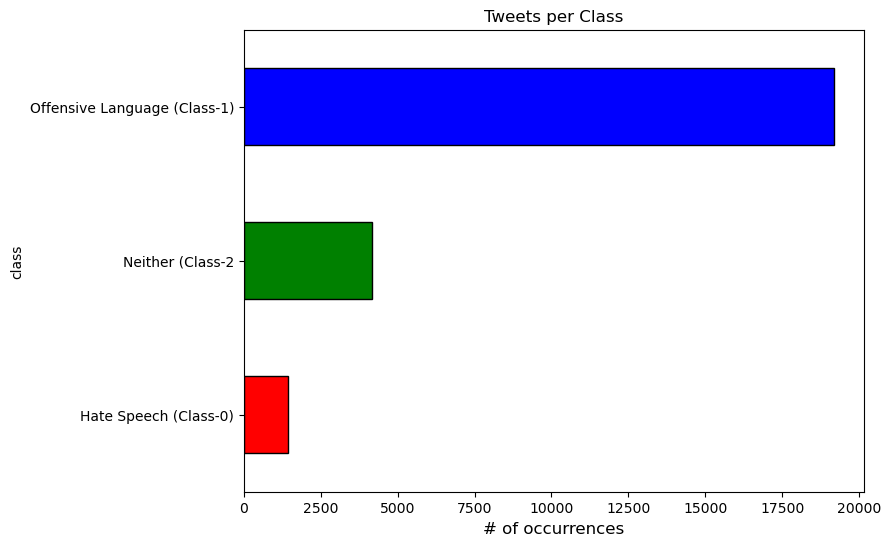

In [10]:
class_labels = {0: 'Hate Speech (Class-0)', 1: 'Offensive Language (Class-1)', 2: 'Neither (Class-2'}
fig = plt.figure(figsize=(8,6))

data.groupby(['class']).tweet.count().rename(index=class_labels).sort_values().plot.barh(color=['red', 'green', 'blue'],edgecolor='black',
    ylim=0, title= 'Tweets per Class')

plt.xlabel('# of occurrences', fontsize = 12);

#### Data Cleaning 

In [11]:
data.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace=True)

In [12]:
data.drop

<bound method DataFrame.drop of        class                                              tweet
0          2  !!! RT @mayasolovely: As a woman you shouldn't...
1          1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2          1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3          1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4          1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...      ...                                                ...
24778      1  you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779      2  you've gone and broke the wrong heart baby, an...
24780      1  young buck wanna eat!!.. dat nigguh like I ain...
24781      1              youu got wild bitches tellin you lies
24782      2  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...

[24783 rows x 2 columns]>

In [13]:
# Function to clean text
def clean_tweets(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'@\w+', '', text)
    return text

# Apply the function to the 'tweet' column
data['cleaned_tweet'] = data['tweet'].apply(lambda x: clean_tweets(str(x)))

In [14]:
# Preprocessing with NLTK
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocessed_tweet(text):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Apply stemming
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Rejoin tokens into a sentence
    return ' '.join(lemmatized_tokens)

# Apply the preprocessing to the 'cleaned tweet' column
data['cleaned_tweet'] = data['cleaned_tweet'].apply(preprocessed_tweet)

In [15]:
data['cleaned_tweet'].head()

0    rt mayasolovely woman shouldnt complain cleani...
1    rt mleew boy dat coldtyga dwn bad cuffin dat h...
2    rt urkindofbrand dawg rt sbabylife ever fuck b...
3             rt cganderson vivabased look like tranny
4    rt shenikaroberts shit hear might true might f...
Name: cleaned_tweet, dtype: object

We will identify the most frequent words in the dataset and choose a num_words value that covers most of the vocabulary.

In [16]:
# using tensorflow t tokenize an pad th lemmatized words
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(data['cleaned_tweet'])

# convert texts to sequence 
data['sequence']= tokenizer.texts_to_sequences(data['cleaned_tweet'])

In [17]:
# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 to include padding (if used)
print('Vocabulary Size:', vocab_size)

# Get the lengths of each tweet
tweet_lengths = [len(seq) for seq in data['sequence']]
print('Tweet Length:',tweet_lengths)

# Get the maximum sequence length (max length)
sequence_length = max(tweet_lengths)
print('Chosen Sequence Length:', sequence_length)

Vocabulary Size: 31459
Tweet Length: [12, 12, 12, 6, 11, 9, 9, 10, 8, 6, 9, 5, 6, 4, 2, 3, 3, 2, 5, 5, 5, 4, 5, 11, 7, 5, 2, 7, 5, 5, 7, 10, 7, 6, 9, 2, 4, 8, 6, 6, 6, 5, 18, 5, 5, 4, 5, 10, 6, 7, 4, 10, 10, 6, 7, 9, 11, 5, 7, 9, 12, 5, 9, 7, 9, 13, 5, 9, 10, 13, 9, 8, 6, 12, 12, 7, 6, 16, 6, 9, 7, 16, 6, 11, 11, 5, 11, 5, 4, 9, 7, 10, 16, 13, 14, 8, 7, 9, 15, 5, 9, 11, 14, 8, 13, 8, 7, 10, 12, 8, 10, 6, 6, 6, 8, 7, 7, 12, 10, 12, 11, 8, 11, 8, 11, 7, 11, 16, 7, 9, 6, 19, 14, 7, 6, 9, 6, 11, 12, 19, 6, 12, 6, 8, 17, 7, 15, 7, 12, 13, 8, 6, 12, 17, 14, 10, 7, 11, 15, 14, 15, 7, 10, 7, 12, 11, 20, 7, 5, 13, 7, 14, 7, 9, 6, 5, 4, 15, 6, 7, 12, 13, 11, 19, 9, 7, 9, 8, 6, 11, 5, 10, 13, 8, 10, 15, 10, 4, 15, 7, 10, 11, 5, 10, 12, 11, 8, 8, 4, 10, 10, 5, 14, 10, 7, 9, 10, 6, 13, 12, 7, 15, 8, 6, 8, 6, 14, 15, 11, 12, 6, 9, 7, 8, 9, 11, 11, 11, 6, 5, 10, 16, 9, 5, 6, 6, 11, 9, 11, 3, 9, 8, 13, 15, 7, 11, 8, 4, 13, 5, 6, 12, 15, 13, 7, 12, 9, 5, 5, 9, 7, 4, 12, 6, 8, 13, 9, 9, 6, 15, 12, 5, 8,

In [18]:
# padding the word sequence 
maxlen = sequence_length
tweet_padded_sequence = pad_sequences(data['sequence'], padding = 'post', maxlen = maxlen)

In [19]:
print('padded sequence :',tweet_padded_sequence.shape)
print('class :', data['class'].shape)

padded sequence : (24783, 30)
class : (24783,)


##### Splitting the Data

In [20]:
# Split the data into training and validation sets.
x_train, x_test, y_train, y_test = train_test_split(
    tweet_padded_sequence,
    data['class'],
    test_size=0.2,
    random_state=42,
    stratify=data['class']
)
print('X_train :- ', x_train.shape)
print('X_test :- ', x_test.shape)
print('Y_train :- ', y_train.shape)
print('Y_test :- ', y_test.shape)

X_train :-  (19826, 30)
X_test :-  (4957, 30)
Y_train :-  (19826,)
Y_test :-  (4957,)


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1609: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1609: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisi

In [21]:
# Convert lists back to numpy arrays
x_train = np.array(x_train.tolist())
x_test = np.array(x_test.tolist())

# Labels remain as numpy arrays automatically
y_train = np.array(y_train)
y_test = np.array(y_test)

In [22]:
# one hot encoding the target variable 
y_train = to_categorical(y_train,num_classes=3)
y_test =  to_categorical(y_test, num_classes=3)

### Build the Deep Learning Model

In [23]:
# function to compute the accuracy, precision, recall and F1 score of a model's predictions.
def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true , y_pred)
    model_precision, model_recall, model_f1,_ = precision_recall_fscore_support(y_true, y_pred,average="weighted")
    model_results = {"accuracy":model_accuracy,
                     "precision":model_precision,
                     "recall" :model_recall,
                     "f1":model_f1}
    return model_results

In [24]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=sequence_length),  # Embedding layer
    Conv1D(filters=64, kernel_size=5, activation='relu'),  # Conv1D for feature extraction
    LSTM(32, return_sequences=False),  # LSTM layer for sequence learning
    Dense(64, activation='relu'),  # Dense layers
    Dense(3, activation='softmax')  # Output layer for 3 classes (offensive, not offensive, neither)
])

# Compile the model for multi-class classification
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',  # Multi-class loss function
    metrics=['accuracy']  # Accuracy as evaluation metric
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [25]:
# Train the model
# Fit the model
base_model = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=1,
)

Train on 19826 samples, validate on 4957 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2024-11-26 20:07:08.837884: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-11-26 20:07:08.842907: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2394290000 Hz
2024-11-26 20:07:08.843458: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559386f0a7a0 executing computations on platform Host. Devices:
2024-11-26 20:07:08.843500: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2024-11-26 20:07:08.910420: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line fl

Epoch 1/10
19826/19826 [==============================] - 108s 5ms/sample - loss: 0.4747 - acc: 0.8390 - val_loss: 0.3461 - val_acc: 0.8850
Epoch 2/10
19826/19826 [==============================] - 104s 5ms/sample - loss: 0.2707 - acc: 0.9130 - val_loss: 0.3418 - val_acc: 0.8866
Epoch 3/10
19826/19826 [==============================] - 105s 5ms/sample - loss: 0.1839 - acc: 0.9375 - val_loss: 0.3931 - val_acc: 0.8697
Epoch 4/10
19826/19826 [==============================] - 104s 5ms/sample - loss: 0.1148 - acc: 0.9653 - val_loss: 0.5087 - val_acc: 0.8669
Epoch 5/10
19826/19826 [==============================] - 106s 5ms/sample - loss: 0.0684 - acc: 0.9801 - val_loss: 0.5006 - val_acc: 0.8646
Epoch 6/10
19826/19826 [==============================] - 104s 5ms/sample - loss: 0.0422 - acc: 0.9880 - val_loss: 0.6401 - val_acc: 0.8402
Epoch 7/10
19826/19826 [==============================] - 104s 5ms/sample - loss: 0.0297 - acc: 0.9910 - val_loss: 0.6965 - val_acc: 0.8511
Epoch 8/10
19826/198

In [26]:
pred = model.predict(x_test)
Y_pred = np.argmax(pred, axis=1)  # Convert probabilities to class labels
Y_test = np.argmax(y_test, axis=1) 

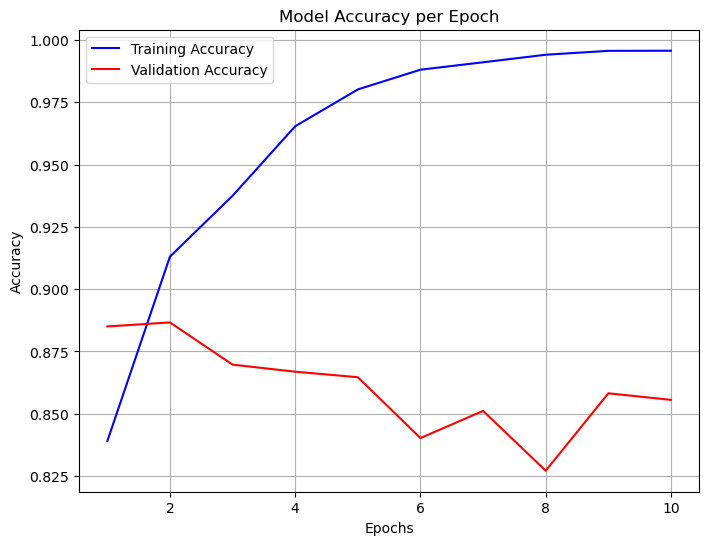

In [27]:
# Extract accuracy and validation accuracy
train_accuracy = base_model.history['acc']
val_accuracy = base_model.history['val_acc']

# Plot accuracy per epoch
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
calculate_results(y_true= Y_test,
                  y_pred = Y_pred)

{'accuracy': 0.8555577970546702,
 'precision': 0.859576271919257,
 'recall': 0.8555577970546702,
 'f1': 0.8573653122845459}

In [31]:
base_model_error = np.mean((Y_test - Y_pred)**2)
print(f"Mean squared error is {base_model_error}\n")

Mean squared error is 0.1777284647972564



#### Applying Dropout Regularization 

In [32]:
d_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=sequence_length),  # Embedding layer
    Conv1D(filters=64, kernel_size=5, activation='relu'),  # Conv1D for feature extraction
    Dropout(0.3),  # Dropout for regularization
    LSTM(32, return_sequences=False),  # LSTM layer for sequence learning
    Dropout(0.3),
    Dense(64, activation='relu'),  # Dense layers
    Dropout(0.2),
    Dense(3, activation='softmax')  # Output layer for 3 classes (offensive, not offensive, neither)
])

# Compile the model for multi-class classification
d_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',  # Multi-class loss function
    metrics=['accuracy']  # Accuracy as evaluation metric
)

In [33]:
# Fit the model
drop_model = d_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=1,
)

Train on 19826 samples, validate on 4957 samples
Epoch 1/10
19826/19826 [==============================] - 104s 5ms/sample - loss: 0.4866 - acc: 0.8317 - val_loss: 0.3476 - val_acc: 0.8780
Epoch 2/10
19826/19826 [==============================] - 101s 5ms/sample - loss: 0.2791 - acc: 0.9109 - val_loss: 0.3431 - val_acc: 0.8836
Epoch 3/10
19826/19826 [==============================] - 104s 5ms/sample - loss: 0.1950 - acc: 0.9313 - val_loss: 0.4252 - val_acc: 0.8755
Epoch 4/10
19826/19826 [==============================] - 100s 5ms/sample - loss: 0.1287 - acc: 0.9565 - val_loss: 0.5503 - val_acc: 0.8525
Epoch 5/10
19826/19826 [==============================] - 99s 5ms/sample - loss: 0.0874 - acc: 0.9738 - val_loss: 0.5863 - val_acc: 0.8525
Epoch 6/10
19826/19826 [==============================] - 100s 5ms/sample - loss: 0.0631 - acc: 0.9817 - val_loss: 0.6440 - val_acc: 0.8457
Epoch 7/10
19826/19826 [==============================] - 103s 5ms/sample - loss: 0.0406 - acc: 0.9892 - val_los

In [34]:
# Make predictions
d_pred = model.predict(x_test)
d_y_pred = np.argmax(d_pred, axis=1)  # Convert probabilities to class labels
d_y_test = np.argmax(y_test, axis=1) 

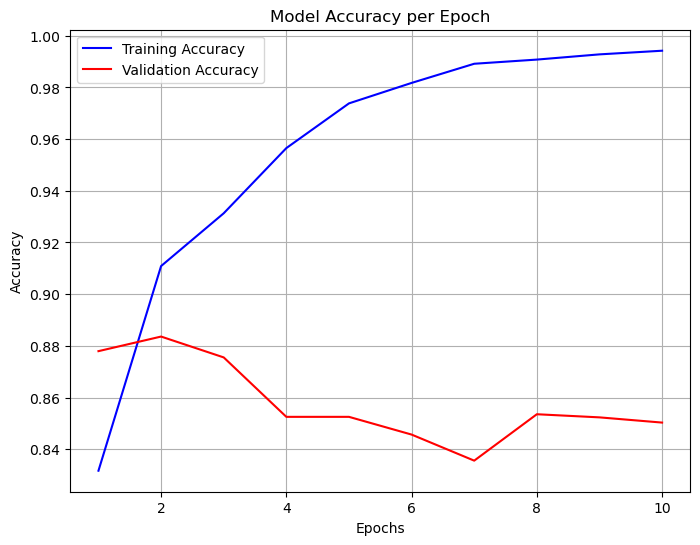

In [35]:
# Extract accuracy and validation accuracy
d_train_accuracy = drop_model.history['acc']
d_val_accuracy = drop_model.history['val_acc']

# Plot accuracy per epoch
epochs = range(1, len(d_train_accuracy) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, d_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, d_val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
calculate_results(y_true=Y_test,
                  y_pred=d_y_pred)

{'accuracy': 0.8555577970546702,
 'precision': 0.859576271919257,
 'recall': 0.8555577970546702,
 'f1': 0.8573653122845459}

In [37]:
d_model_error = np.mean((Y_test - d_y_pred)**2)
print(f"Mean squared error is {d_model_error}\n")

Mean squared error is 0.1777284647972564



### Applying Lasso Regularization (L1)

In [38]:
model_l1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length= sequence_length),  # Embedding layer
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l1(0.01)),  # Conv1D for feature extraction
    LSTM(32, return_sequences=False,kernel_regularizer=l1(0.01)),  # LSTM layer for sequence learning
    Dense(64,activation='relu', kernel_regularizer=l1(0.01)),  # Dense layers
    Dense(3, activation='softmax')  # Output layer for 3 classes (offensive, not offensive, neither)
])

# Compile the model for multi-class classification
model_l1.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',  # Multi-class loss function
    metrics=['accuracy']  # Accuracy as evaluation metric
)

In [39]:
# Fit the model
L1_model = model_l1.fit(
    x_train, y_train,  # Ensure y_train is one-hot encoded
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),  # Ensure y_test is also one-hot encoded
    verbose=1
)

Train on 19826 samples, validate on 4957 samples
Epoch 1/10
19826/19826 [==============================] - 104s 5ms/sample - loss: 2.2880 - acc: 0.7743 - val_loss: 0.7105 - val_acc: 0.7743
Epoch 2/10
19826/19826 [==============================] - 102s 5ms/sample - loss: 0.7045 - acc: 0.7743 - val_loss: 0.7038 - val_acc: 0.7743
Epoch 3/10
19826/19826 [==============================] - 102s 5ms/sample - loss: 0.6988 - acc: 0.7743 - val_loss: 0.6949 - val_acc: 0.7743
Epoch 4/10
19826/19826 [==============================] - 101s 5ms/sample - loss: 0.6957 - acc: 0.7743 - val_loss: 0.6954 - val_acc: 0.7743
Epoch 5/10
19826/19826 [==============================] - 101s 5ms/sample - loss: 0.6952 - acc: 0.7743 - val_loss: 0.6947 - val_acc: 0.7743
Epoch 6/10
19826/19826 [==============================] - 99s 5ms/sample - loss: 0.6948 - acc: 0.7743 - val_loss: 0.6945 - val_acc: 0.7743
Epoch 7/10
19826/19826 [==============================] - 99s 5ms/sample - loss: 0.6949 - acc: 0.7743 - val_loss

In [40]:
# Make predictions
L1_pred = model_l1.predict(x_test)
L1_y_pred = np.argmax(L1_pred, axis=1)  # Convert probabilities to class labels

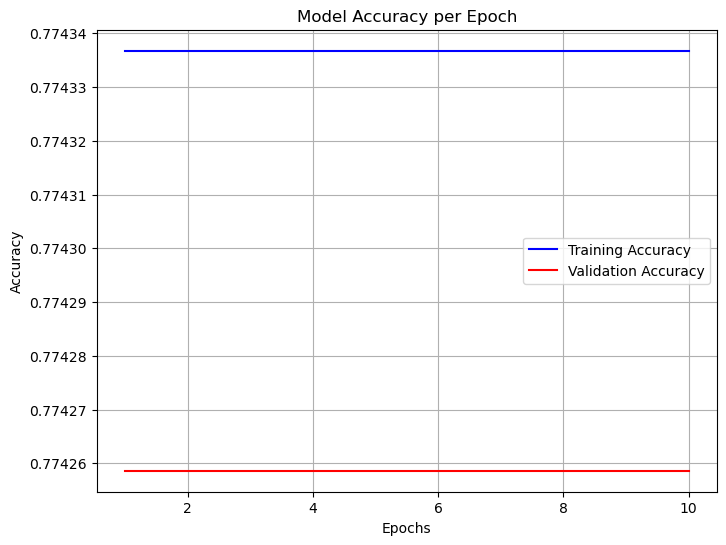

In [41]:
# Extract accuracy and validation accuracy
L1_train_accuracy = L1_model.history['acc']
L1_val_accuracy = L1_model.history['val_acc']

# Plot accuracy per epoch
epochs = range(1, len(L1_train_accuracy) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, L1_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, L1_val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
calculate_results(y_true=Y_test,
                  y_pred=L1_y_pred)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'accuracy': 0.7742586241678434,
 'precision': 0.5994764170982818,
 'recall': 0.7742586241678434,
 'f1': 0.6757486298024294}

In [43]:
L1_model_error = np.mean((Y_test - L1_y_pred)**2)
print(f"Mean squared error is {L1_model_error}\n")

Mean squared error is 0.22574137583215656



 ### Applying Ridge Regularization (L2)

In [44]:
model_l2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length= sequence_length),  # Embedding layer
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),  # Conv1D for feature extraction
    LSTM(32, return_sequences=False,kernel_regularizer=l2(0.01)),  # LSTM layer for sequence learning
    Dense(64,activation='relu', kernel_regularizer=l2(0.01)),  # Dense layers
    Dense(3, activation='softmax')  # Output layer for 3 classes (offensive, not offensive, neither)
])

# Compile the model for multi-class classification
model_l2.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',  # Multi-class loss function
    metrics=['accuracy']  # Accuracy as evaluation metric
)

In [45]:
# Fit the model
l2_model = model_l2.fit(
    x_train, y_train,  # Ensure y_train is one-hot encoded
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),  # Ensure y_test is also one-hot encoded
    verbose=1
)

Train on 19826 samples, validate on 4957 samples
Epoch 1/10
19826/19826 [==============================] - 102s 5ms/sample - loss: 0.6726 - acc: 0.8379 - val_loss: 0.3699 - val_acc: 0.8856
Epoch 2/10
19826/19826 [==============================] - 99s 5ms/sample - loss: 0.2392 - acc: 0.9288 - val_loss: 0.4292 - val_acc: 0.8600
Epoch 4/10
19826/19826 [==============================] - 101s 5ms/sample - loss: 0.2038 - acc: 0.9390 - val_loss: 0.4391 - val_acc: 0.8533
Epoch 5/10
19826/19826 [==============================] - 99s 5ms/sample - loss: 0.1797 - acc: 0.9504 - val_loss: 0.5591 - val_acc: 0.8241
Epoch 6/10
19826/19826 [==============================] - 99s 5ms/sample - loss: 0.1589 - acc: 0.9591 - val_loss: 0.5099 - val_acc: 0.8340
Epoch 7/10
19826/19826 [==============================] - 99s 5ms/sample - loss: 0.1381 - acc: 0.9677 - val_loss: 0.5941 - val_acc: 0.8251
Epoch 8/10
19826/19826 [==============================] - 97s 5ms/sample - loss: 0.1272 - acc: 0.9706 - val_loss: 0

In [46]:
# Make predictions
L2_pred = model_l2.predict(x_test)
L2_y_pred = np.argmax(L2_pred, axis=1)

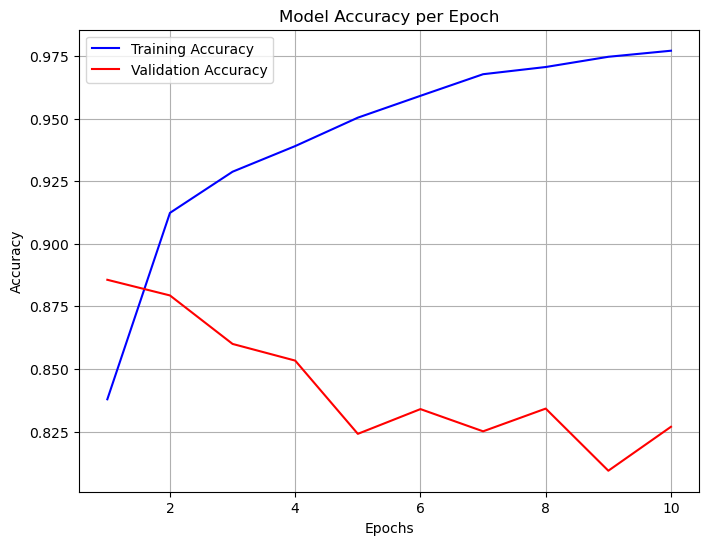

In [47]:
# Extract accuracy and validation accuracy
L2_train_accuracy = l2_model.history['acc']
L2_val_accuracy = l2_model.history['val_acc']

# Plot accuracy per epoch
epochs = range(1, len(L2_train_accuracy) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, L2_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, L2_val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
calculate_results(y_true=Y_test,
                  y_pred=L2_y_pred)

{'accuracy': 0.8269114383699818,
 'precision': 0.8529125123702188,
 'recall': 0.8269114383699818,
 'f1': 0.8345707869564174}

In [49]:
L2_model_error = np.mean((Y_test- L2_y_pred)**2)
print(f"Mean squared error is {L2_model_error}\n")

Mean squared error is 0.3116804518862215



### Applying Batch Normalization

In [50]:
b_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=sequence_length),  # Embedding layer
    Conv1D(filters=64, kernel_size=5, activation='relu'),  # Conv1D for feature extraction
    BatchNormalization(),
    LSTM(32, return_sequences=False),  # LSTM layer for sequence learning
    BatchNormalization(),
    Dense(64, activation='relu'),  # Dense layers
    BatchNormalization(),
    Dense(3, activation='softmax')  # Output layer for 3 classes (offensive, not offensive, neither)
])

# Compile the model for multi-class classification
b_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',  # Multi-class loss function
    metrics=['accuracy']  # Accuracy as evaluation metric
)

In [51]:
# Fit the model
batch_model = b_model.fit(
    x_train, y_train,  # Ensure y_train is one-hot encoded
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),  # Ensure y_test is also one-hot encoded
    verbose=1
)

Train on 19826 samples, validate on 4957 samples
Epoch 1/10
19826/19826 [==============================] - 106s 5ms/sample - loss: 0.4806 - acc: 0.8361 - val_loss: 0.6261 - val_acc: 0.8346
Epoch 2/10
19826/19826 [==============================] - 102s 5ms/sample - loss: 0.2377 - acc: 0.9215 - val_loss: 0.6224 - val_acc: 0.7981
Epoch 3/10
19826/19826 [==============================] - 104s 5ms/sample - loss: 0.1248 - acc: 0.9609 - val_loss: 0.4784 - val_acc: 0.8876
Epoch 4/10
19826/19826 [==============================] - 100s 5ms/sample - loss: 0.0719 - acc: 0.9776 - val_loss: 5.2238 - val_acc: 0.1493
Epoch 5/10
19826/19826 [==============================] - 100s 5ms/sample - loss: 0.0536 - acc: 0.9826 - val_loss: 4.8556 - val_acc: 0.1943
Epoch 6/10
19826/19826 [==============================] - 101s 5ms/sample - loss: 0.0327 - acc: 0.9901 - val_loss: 4.5013 - val_acc: 0.1747
Epoch 7/10
19826/19826 [==============================] - 101s 5ms/sample - loss: 0.0277 - acc: 0.9920 - val_lo

In [52]:
# Make predictions
b_pred = b_model.predict(x_test)
b_y_pred = np.argmax(b_pred, axis=1)

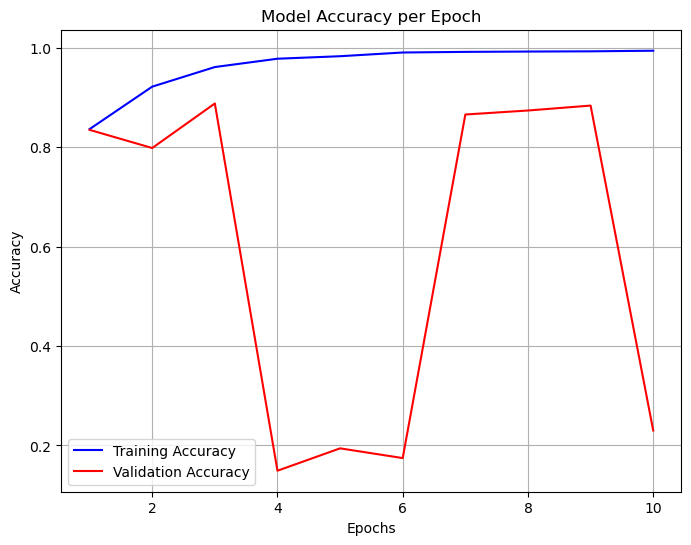

In [53]:
# Extract accuracy and validation accuracy
b_train_accuracy = batch_model.history['acc']
b_val_accuracy = batch_model.history['val_acc']

# Plot accuracy per epoch
epochs = range(1, len(b_train_accuracy) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, b_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, b_val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
calculate_results(y_true=Y_test,
                  y_pred=b_y_pred)

{'accuracy': 0.2301795440790801,
 'precision': 0.7680284923566465,
 'recall': 0.2301795440790801,
 'f1': 0.1669755002453377}

In [55]:
b_model_error = np.mean((Y_test-b_y_pred)**2)
print(f"Mean squared error is {b_model_error}\n")

Mean squared error is 0.9295945128101675



### Applying Data Shuffling 

In [56]:
s_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=sequence_length),  # Embedding layer
    Conv1D(filters=64, kernel_size=5, activation='relu'),  # Conv1D for feature extraction
    LSTM(32, return_sequences=False),  # LSTM layer for sequence learning
    Dense(64, activation='relu'),  # Dense layers
    Dense(3, activation='softmax')  # Output layer for 3 classes (offensive, not offensive, neither)
])

# Compile the model for multi-class classification
s_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',  # Multi-class loss function
    metrics=['accuracy']  # Accuracy as evaluation metric
)

In [57]:
# Fit the model
sh_model = s_model.fit(
    x_train, y_train,  # Ensure y_train is one-hot encoded
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),
    shuffle = True
)

Train on 19826 samples, validate on 4957 samples
Epoch 1/10
19826/19826 [==============================] - 104s 5ms/sample - loss: 0.5517 - acc: 0.8130 - val_loss: 0.4331 - val_acc: 0.8608
Epoch 2/10
19826/19826 [==============================] - 101s 5ms/sample - loss: 0.3329 - acc: 0.8942 - val_loss: 0.3566 - val_acc: 0.8818
Epoch 3/10
19826/19826 [==============================] - 103s 5ms/sample - loss: 0.2269 - acc: 0.9263 - val_loss: 0.3896 - val_acc: 0.8725
Epoch 4/10
19826/19826 [==============================] - 101s 5ms/sample - loss: 0.1518 - acc: 0.9508 - val_loss: 0.4413 - val_acc: 0.8628
Epoch 5/10
19826/19826 [==============================] - 100s 5ms/sample - loss: 0.0944 - acc: 0.9717 - val_loss: 0.4767 - val_acc: 0.8630
Epoch 6/10
19826/19826 [==============================] - 101s 5ms/sample - loss: 0.0562 - acc: 0.9842 - val_loss: 0.5719 - val_acc: 0.8493
Epoch 7/10
19826/19826 [==============================] - 102s 5ms/sample - loss: 0.0362 - acc: 0.9898 - val_lo

In [58]:
# Make predictions
s_pred = s_model.predict(x_test)
s_y_pred = np.argmax(s_pred, axis=1)

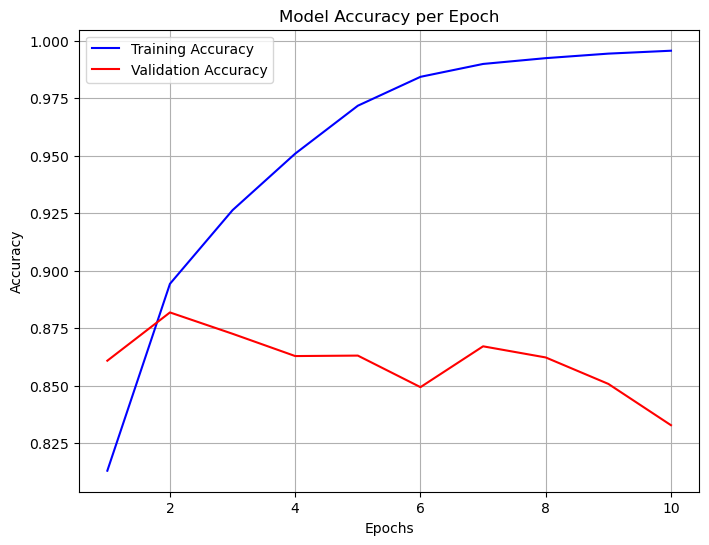

In [59]:
# Extract accuracy and validation accuracy
sh_train_accuracy = sh_model.history['acc']
sh_val_accuracy = sh_model.history['val_acc']

# Plot accuracy per epoch
epochs = range(1, len(sh_train_accuracy) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, sh_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, sh_val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
calculate_results(y_true=Y_test,
                  y_pred=s_y_pred)

{'accuracy': 0.8327617510591083,
 'precision': 0.8489429063417547,
 'recall': 0.8327617510591083,
 'f1': 0.8370752663511594}

In [61]:
s_model_error = np.mean((Y_test-s_y_pred)**2)
print(f"Mean squared error is {s_model_error}\n")

Mean squared error is 0.2114181964898124



### Combining Different Regularization

In [62]:
c_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=sequence_length),
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LSTM(32, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.01),return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(3, activation='softmax'),
])

# Compile the model
c_model.compile(
    optimizer = Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [63]:
# Fit the model
com_model = c_model.fit(
    x_train, y_train,  # Ensure y_train is one-hot encoded
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),
    shuffle = True
)

Train on 19826 samples, validate on 4957 samples
Epoch 1/10
19826/19826 [==============================] - 123s 6ms/sample - loss: 0.8574 - acc: 0.7926 - val_loss: 0.7780 - val_acc: 0.7773
Epoch 2/10
19826/19826 [==============================] - 119s 6ms/sample - loss: 0.4636 - acc: 0.8495 - val_loss: 0.4312 - val_acc: 0.8616
Epoch 3/10
19826/19826 [==============================] - 117s 6ms/sample - loss: 0.4094 - acc: 0.8735 - val_loss: 0.4018 - val_acc: 0.8636
Epoch 4/10
19826/19826 [==============================] - 118s 6ms/sample - loss: 0.3753 - acc: 0.8896 - val_loss: 0.4246 - val_acc: 0.8344
Epoch 5/10
19826/19826 [==============================] - 118s 6ms/sample - loss: 0.3533 - acc: 0.8985 - val_loss: 0.4314 - val_acc: 0.8743
Epoch 6/10
19826/19826 [==============================] - 120s 6ms/sample - loss: 0.3034 - acc: 0.9144 - val_loss: 0.4149 - val_acc: 0.8828
Epoch 7/10
19826/19826 [==============================] - 118s 6ms/sample - loss: 0.2983 - acc: 0.9184 - val_lo

In [64]:
# Make predictions
c_pred = c_model.predict(x_test)
c_y_pred = np.argmax(c_pred, axis=1)

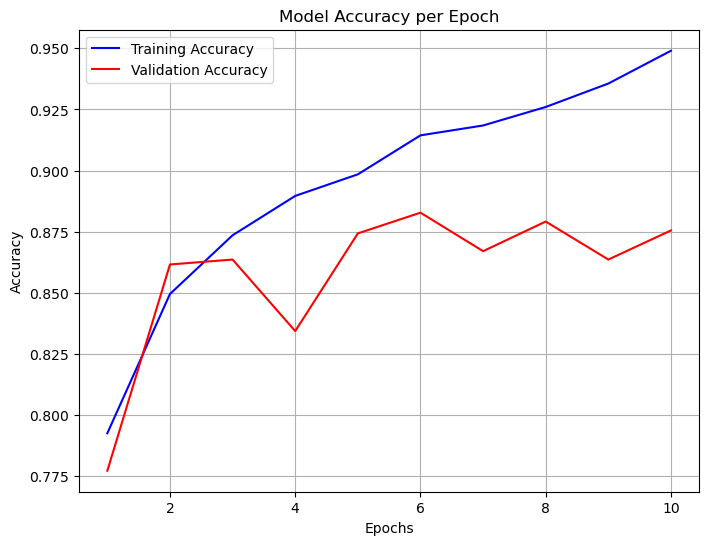

In [65]:
# Extract accuracy and validation accuracy
com_train_accuracy = com_model.history['acc']
com_val_accuracy = com_model.history['val_acc']

# Plot accuracy per epoch
epochs = range(1, len(com_train_accuracy) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, com_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, com_val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [66]:
calculate_results(y_true=Y_test,
                  y_pred=c_y_pred)

{'accuracy': 0.8755295541658261,
 'precision': 0.870110137355862,
 'recall': 0.8755295541658261,
 'f1': 0.8726357844791421}

In [67]:
c_model_error = np.mean((Y_test-c_y_pred)**2)
print(f"Mean squared error is {c_model_error}\n")

Mean squared error is 0.15654629816421223



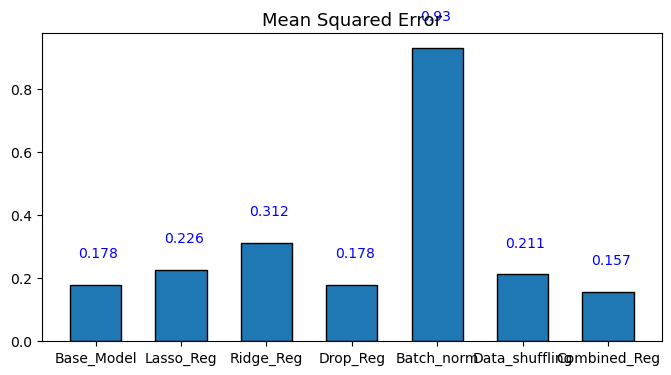

In [73]:
# plotting the error of the different models 
models= ['Base_Model','Lasso_Reg','Ridge_Reg','Drop_Reg','Batch_norm','Data_shuffling','Combined_Reg']
error = [base_model_error, L1_model_error, L2_model_error, d_model_error, b_model_error, s_model_error, c_model_error]
plt.figure(figsize=(8, 4))
plt.bar(models, error, width=0.6, edgecolor = 'black')
plt.title("Mean Squared Error ", fontsize=13)
for i, err in enumerate(error):
    plt.text(i-0.2, err+0.1, str(round(err,3)), color='blue', va='center') 

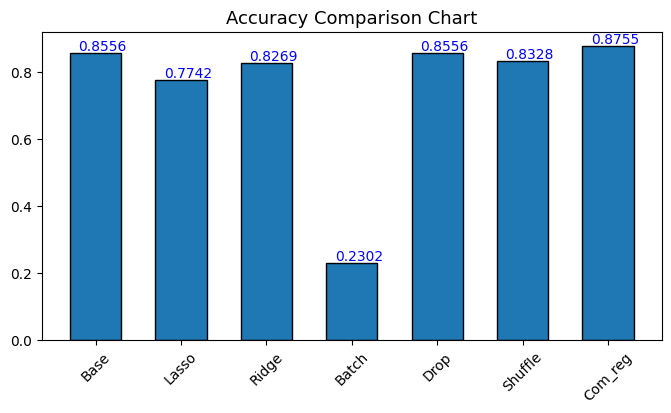

In [2]:
models = ['Base','Lasso','Ridge','Batch','Drop','Shuffle','Com_reg']
Accuracy = [0.8556,0.7742,0.8269,0.2302,0.8556,0.8328,0.8755]
Precision = [0.8596,0.5994,0.8529,0.7680,0.8596,0.8489,0.8701]
Recall = [0.8556,0.7742,0.8269,0.2302,0.8556,0.8328,0.8755]
F1_Score = [0.8574,0.6757,0.8346,0.1669,0.8574,0.8371,0.8726]

# plotting the Accuracy of the different models 
plt.figure(figsize=(8, 4))
plt.bar(models, Accuracy, width=0.6, edgecolor = 'black')
plt.title("Accuracy Comparison Chart", fontsize=13)
plt.xticks(rotation = 45)
for i, acc in enumerate(Accuracy):
    plt.text(i-0.2, acc+0.02, str(round(acc,4)), color='blue', va='center') 
plt.show()

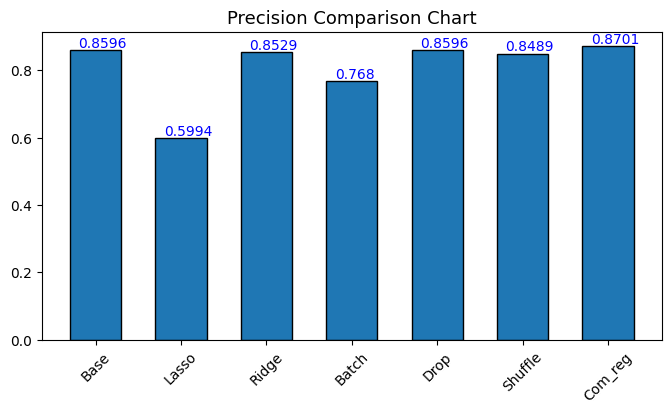

In [3]:
# plotting the Precision of the different models 
plt.figure(figsize=(8, 4))
plt.bar(models, Precision, width=0.6, edgecolor = 'black')
plt.title("Precision Comparison Chart", fontsize=13)
plt.xticks(rotation = 45)
for i, pres in enumerate(Precision):
    plt.text(i-0.2, pres+0.02, str(round(pres,4)), color='blue', va='center') 
plt.show()

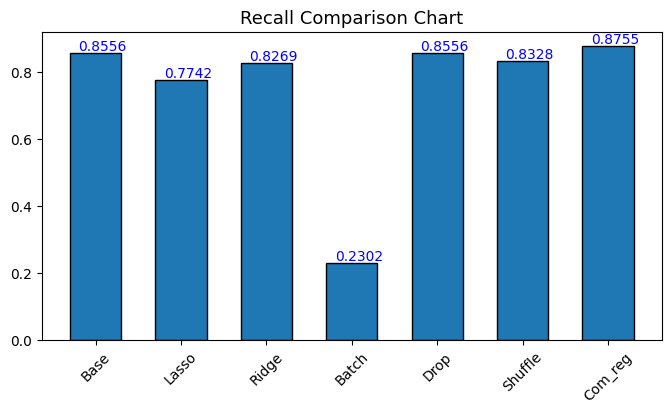

In [4]:
# plotting the Recall of the different models 
plt.figure(figsize=(8, 4))
plt.bar(models, Recall, width=0.6, edgecolor = 'black')
plt.title("Recall Comparison Chart", fontsize=13)
plt.xticks(rotation = 45)
for i, re in enumerate(Recall):
    plt.text(i-0.2, re+0.02, str(round(re,4)), color='blue', va='center') 
plt.show()

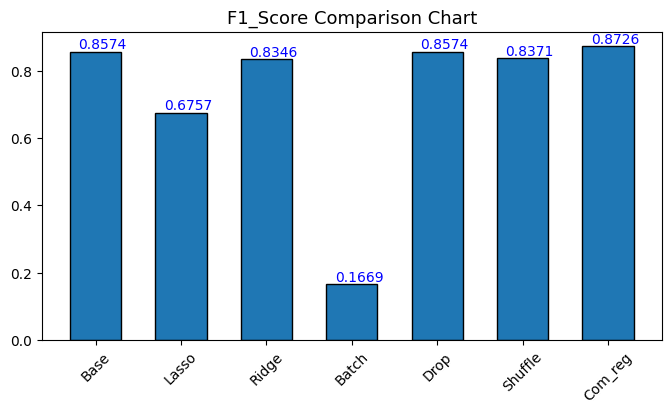

In [5]:
# plotting the F1_Score of the different models 
plt.figure(figsize=(8, 4))
plt.bar(models, F1_Score, width=0.6, edgecolor = 'black')
plt.title("F1_Score Comparison Chart", fontsize=13)
plt.xticks(rotation = 45)
for i, f1 in enumerate(F1_Score):
    plt.text(i-0.2, f1+0.02, str(round(f1,4)), color='blue', va='center') 
plt.show()